# Лабораторная №4

In [5]:
class Solver(Params):

    def __init__(self):

        super().__init__()
    
        self.x0 = 0
        self.xN = self.l

        self.N = 1000
        self.h = (self.xN - self.x0) / self.N

    def A(self, y: list, n):
        return (self.Lambda(y[n]) + self.Lambda(y[n - 1])) * self.tau / (2 * self.h)
    
    def D(self, y: list, n):
        return (self.Lambda(y[n]) + self.Lambda(y[n + 1])) * self.tau / (2 * self.h)
    
    def B(self, x, y: list, n):
        return self.A(y, n) + self.D(y, n) + self.C(y[n]) * self.h + self.p(x) * self.tau * self.h
    
    def F(self, x, y: list, n, tcur):
        return (self.C(y[n]) * y[n] + self.f(x, y[n], tcur) * self.tau) * self.h
    
    def K0(self, y: list):
        c0 = self.C(y[0])
        c1 = self.C(y[1])

        c1_2 = (c0 + c1) / 2

        F = (self.Lambda(y[0]) + self.Lambda(y[1])) * self.tau / (2 * self.h)

        p0 = self.p(self.x0)
        p1_2 = (p0 + self.p(self.x0 + self.h)) / 2
        
        return (c1_2 * self.h) / 8 + c0 * self.h / 4 + self.alpha(0) * self.tau + F + (self.h * self.tau / 4) * (p1_2 / 2 + p0)    

    def M0(self, y: list):
        c0 = self.C(y[0])
        c1 = self.C(y[1])

        c1_2 = (c0 + c1) / 2

        F = (self.Lambda(y[0]) + self.Lambda(y[1])) * self.tau / (2 * self.h)

        p0 = self.p(self.x0)
        p1_2 = (p0 + self.p(self.x0 + self.h)) / 2
        
        return (c1_2 * self.h) / 8 - F + self.h * self.tau * p1_2 / 8

    def P0(self, y: list, tcur):
        c0 = self.C(y[0])
        c1 = self.C(y[1])

        c1_2 = (c0 + c1) / 2

        f0 = self.f(self.x0, y[0], tcur)
        f1 = self.f(self.x0 + self.h, y[1], tcur)
        f1_2 = (f0 + f1) /2
        
        p1 = (self.h / 4) * (c1_2 * (y[0] + y[1]) / 2 + c0 * y[0])
        p2 = self.alpha(self.x0) * self.T0 * self.tau
        p3 = (self.h * self.tau / 4) * (f1_2 + f0)

        # print("alpha 0:", self.alpha(self.x0))

        return p1 + p2 + p3 
    
    def KN(self, y: list):
        N = self.N - 1

        cN = self.C(y[N])
        cN_1 = self.C(y[N - 1])

        cN1_2 = (cN + cN_1) / 2

        F = (self.Lambda(y[N]) + self.Lambda(y[N - 1])) * self.tau / (2 * self.h)

        pN = self.p(self.xN)
        pN1_2 = (pN + self.p(self.xN - self.h)) / 2
        
        return (cN1_2 * self.h) / 8 - F + self.h * self.tau * pN1_2 / 8

    def MN(self, y: list):
        N = self.N - 1

        cN = self.C(y[N])
        cN_1 = self.C(y[N - 1])

        cN1_2 = (cN + cN_1) / 2

        F = (self.Lambda(y[N]) + self.Lambda(y[N - 1])) * self.tau / (2 * self.h)

        pN = self.p(self.xN)
        pN1_2 = (pN + self.p(self.xN - self.h)) / 2
        
        return (cN1_2 * self.h) / 8 + cN * self.h / 4 - self.alpha(self.xN) * self.tau + F + (self.h * self.tau / 4) * (pN1_2 / 2 + pN)    

    def PN(self, y: list, tcur):
        N = self.N - 1
        
        cN = self.C(y[N])
        cN_1 = self.C(y[N - 1])

        cN1_2 = (cN + cN_1) / 2

        fN = self.f(self.xN, y[N], tcur)
        fN_1 = self.f(self.xN - self.h, y[N - 1], tcur)

        fN1_2 = (fN + fN_1) / 2
        
        p1 = (self.h / 4) * (cN1_2 * (y[N - 1] + y[N]) / 2 + cN * y[N])
        p2 = -self.alpha(self.xN) * self.T0 * self.tau
        p3 = (self.h * self.tau / 4) * (fN1_2 + fN)

        # print("alpha n:", self.alpha(self.xN))

        return p1 + p2 + p3  
    
    def rightRun(self, c, d, e, f):

        # прогоночные коэффициенты
        a = np.zeros(self.N)
        b = np.zeros(self.N)

        # решение системы
        u = np.zeros(self.N)

        # прямой ход : находим a, b
        for i in range(self.N - 1):

            if i == 0:
                a[i + 1] = -e[i] / d[i]
                b[i + 1] = f[i] / d[i]
            else:
                zn = c[i] * a[i] + d[i]

                a[i + 1] = -e[i] / zn
                b[i + 1] = (f[i] - c[i] * b[i]) / zn

            # print(a[i], b[i])

        # обратный ход : находим u
        for i in range(self.N - 1, -1, -1):

            if i == self.N - 1:
                u[i] = (f[i] - c[i] * b[i]) / (c[i] * a[i] + d[i])
            else:   
                u[i] = a[i + 1] * u[i + 1] + b[i + 1]
        
        return u
    
    def run(self, y: list, tcur):

        f = np.zeros(self.N)
        c = np.zeros(self.N)
        d = np.zeros(self.N)
        e = np.zeros(self.N)

        x = self.x0

        for i in range(self.N):

            if i == 0:
                d[i] = self.K0(y)
                e[i] = self.M0(y)
                f[i] = self.P0(y, tcur)

            elif i == self.N - 1:
                c[i] = self.KN(y)
                d[i] = self.MN(y)
                f[i] = self.PN(y, tcur)

            else:
                c[i] = self.A(y, i)
                d[i] = -self.B(x, y, i)
                e[i] = self.D(y, i)
                
                f[i] = -self.F(x, y, i, tcur)

            x += self.h
    
        y = self.rightRun(c, d, e, f)

        return y

    def Solve(self):

        eps = 1e-4

        tcur = 0 + self.tau
        yOld = np.full(self.N, self.T0)
        yNew = self.run(yOld, tcur)

        err = np.max((yOld - yNew) / yNew)
        T = np.empty((self.N, self.N))

        T[0, :] = yOld
        t = np.array([tcur])

        for i in range(1, self.N):

            while np.max(err) > eps:

                yNew = self.run(yOld, tcur)

                err = np.abs((yOld - yNew) / yNew)

                yOld = yNew.copy()

            T[i, :] = yNew

            tcur += self.tau
            t = np.append(t, tcur)

        return T, t
 

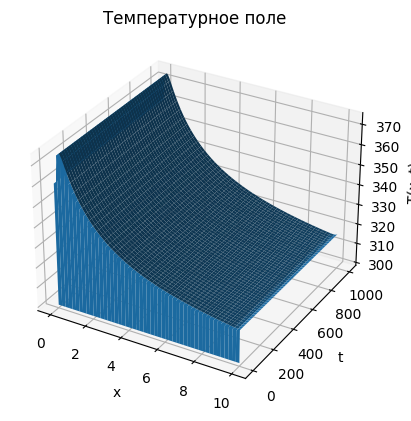

In [9]:
s = Solver()
T, t = s.Solve()

x = np.linspace(s.x0, s.xN, s.N)

x, y = np.meshgrid(x, t)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, T)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T(x, t)')
ax.set_title('Температурное поле')
plt.show()

# plt.grid(True)
# # plt.plot(x, yOld, c = 'red')
# plt.plot(x, yNew, c = 'blue')
# plt.show()

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import prettytable as pt
# from scipy import integrate
# from scipy.interpolate import InterpolatedUnivariateSpline

In [8]:
class Params:

    def __init__(self):
        self.a = [0.0134, 2.049]
        self.b = [1, 0.563e-3]
        self.c = [4.35 * 1e-4, 0.528 * 1e5]
        self.m = [1, 1]
        self.l = 10
        self.T0 = 300
        self.R = 0.5
        self.k0 = 1

        self.Fmax = 50
        self.tmax = 60

        self.tau = 1
    
    def F0(self, t):
        return self.Fmax * t * np.exp(-(t / (self.tmax - 1))) / self.tmax
    
    def Lambda(self, T):
        return self.a[0] * (self.b[0] + self.c[0] * T ** (self.m[0]))
    
    def C(self, T):
        return self.a[1] + self.b[1] * T ** self.m[1] - self.c[1] / (T ** 2)
    
    def k(self, T):
        return self.k0 * (T / 300) ** 2

    def alpha(self, x):
        d = -self.l / 4
        c = -0.05 * d
        return c / (x - d)
    
    def p(self, x):
        return (-2 / self.R) * self.alpha(x)

    def f(self, x, T, t):
        return self.k(T) * self.F0(t) * np.exp(-self.k(T) * x) + 2 * self.T0 * self.alpha(x) / self.R


## Задание 1

## Задание 2

## Задание 3

## Задание 4